# 🦸 Zain and the Power of Kindness — Comic Book Generator
### AI-Powered Children's Comic Book using Stable Diffusion XL

**Instructions:** Runtime → Change runtime type → **T4 GPU** → Run All

---
**Pipeline Overview:**
1. Install dependencies
2. Load SDXL model
3. Validate token counts (must be < 77)
4. Generate all 13 comic panels
5. Burn speech bubbles & captions onto images
6. Assemble final PDF (cover page + 2 panels per page)


## 📦 Step 1: Install Dependencies

In [2]:
# Install all required packages
!pip install -q diffusers transformers accelerate torch Pillow fpdf2 xformers
print("✅ All packages installed successfully!")

✅ All packages installed successfully!


## 📚 Step 2: Imports & Configuration

In [3]:
# Force install the fpdf2 library right before importing it to prevent errors
!pip install -q fpdf2

import torch
import textwrap
import os
import json
import math
from pathlib import Path

from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from transformers import CLIPTokenizer

from PIL import Image, ImageDraw, ImageFont
import numpy as np

from fpdf import FPDF
import IPython.display as display

# ── Directories ──────────────────────────────────────────────────────────────
PANELS_DIR = Path("panels")
PANELS_DIR.mkdir(exist_ok=True)
OUTPUT_PDF  = "Zain_Comic_Book.pdf"

# ── Device ────────────────────────────────────────────────────────────────────
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32
print(f"✅ Using device: {DEVICE}  |  dtype: {DTYPE}")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


✅ Using device: cuda  |  dtype: torch.float16


## 🎨 Step 3: Prompt Engineering Constants

In [4]:
# ── Style wrappers ────────────────────────────────────────────────────────────
STYLE_PREFIX    = "Vibrant modern 2D cartoon, cute children's TV show style, bold clean lines, bright cheerful colors, "
QUALITY_SUFFIX  = ", highly detailed 2D illustration, masterpiece"

# Updated Negative Prompt to catch color mixing and extra characters
NEGATIVE_PROMPT = (
    "3d, realistic, photography, shading, multiple people, extra characters, multiple girls, "
    "crowd, text, watermark, deformed, ugly, extra fingers, floating objects, color mixing, mutated faces"
)

# ── Story JSON ────────────────────────────────────────────────────────────────
STORY_JSON = [
  {
    "panel": 0,
    "text": "Zain and the Power of Kindness",
    "prompt": "Family portrait, cute 6-year-old boy with big brown eyes and short dark hair in a yellow t-shirt standing between his father in a green sweater and his mother in a pink blouse, smiling"
  },
  {
   "panel": 1,
    "text": "Zain: I wish I could be a superhero!\nDad: Being a superhero starts with a kind heart.",
    "prompt": "cute 6-year-old boy with big brown eyes short dark hair yellow t-shirt sitting on sofa next to young man in green sweater, both facing each other talking, cozy living room"
   },
  {
    "panel": 2,
    "text": "Narration: Zain sees a little girl crying. Her balloon is stuck on a tree branch.",
    "prompt": "cute 6-year-old boy yellow t-shirt standing next to one sad crying little girl pink dress, small red balloon tangled on tree branch high above, park background, only two children"
  },
  {
    "panel": 3,
    "text": "Zain: Don't cry! I will get it for you!",
    "prompt": "cute 6-year-old boy with big brown eyes and short dark hair in a yellow t-shirt climbing up a tree trunk, reaching toward a red balloon on a branch, sunny park, close up face"
  },
  {
    "panel": 4,
    "text": "Narration: As he helps, he feels a magical change...",
    "prompt": "Magical glow, cute 6-year-old boy with big brown eyes and short dark hair transforming, wearing a blue superhero suit with a yellow Z emblem on the chest and a red cape, sparkles"
  },
  {
     "panel": 5,
    "text": "Girl: Thank you Zain!",
    "prompt": "cute 6-year-old boy in blue superhero suit yellow Z on chest red cape handing red balloon to happy little girl in pink dress, park"
 },
  {
    "panel": 6,
    "text": "Narration: At school, a boy sits alone at lunch.",
    "prompt": "sad lonely little boy with brown hair wearing an orange shirt sitting alone at a school cafeteria table with a lunch tray, bright cafeteria"
  },
  {
    "panel": 7,
    "text": "Zain: Come sit with us!",
    "prompt": "cute 6-year-old boy with big brown eyes short dark hair solid yellow t-shirt leaning over school cafeteria table toward sad boy with brown hair orange shirt, school cafeteria background"
    },
  {
    "panel": 8,
    "text": "Narration: Now they are all laughing together!",
    "prompt": "cute 6-year-old boy yellow t-shirt laughing together with two other boys at school cafeteria table, lunch trays, three boys sitting together smiling, bright cafeteria"
   },
  {
    "panel": 9,
    "text": "Narration: A small hungry cat meows softly in the street.",
    "prompt": "small cute ginger kitten sitting alone on a sidewalk meowing, big sad eyes, simple street background, closeup shot"
  },
  {
    "panel": 10,
    "text": "Zain: Here little kitty, have some food!",
    "prompt": "cute 6-year-old boy with big brown eyes and short dark hair in a yellow t-shirt crouching down offering a sandwich to a small ginger kitten on a sidewalk, kitten eating happily"
  },
   {
    "panel": 11,
    "text": "Sister: This math is too hard!\nZain: Let me help you.",
    "prompt": "cute 6-year-old boy with big brown eyes short dark hair solid yellow t-shirt standing beside a desk, young girl sitting at desk frowning at math homework with equations on paper, simple bedroom background"
  },
  {
    "panel": 12,
    "text": "Narration: Together they solved every problem!",
    "prompt": "cute 6-year-old boy with big brown eyes short dark hair solid yellow t-shirt pointing at math homework on desk, young girl smiling looking at paper, simple bedroom, warm light, side by side"
  },
  {
    "panel": 13,
    "text": "Zain: I don't need magic to be a hero. Kindness is my Superpower!",
    "prompt": "cute 6-year-old boy with big brown eyes and short dark hair in a blue superhero suit with a large yellow letter Z on the chest and a red cape, standing facing camera heroic pose, simple orange sunset city skyline"

  }
]

print(f"✅ Story loaded: {len(STORY_JSON)} panels")

✅ Story loaded: 14 panels


## 🔍 Step 4: Token Checker (CLIP — must stay < 77 tokens)

In [5]:
# Load CLIP tokenizer to validate prompt lengths
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

MAX_TOKENS = 77
all_ok = True

print(f"{'Panel':>6}  {'Tokens':>6}  {'Status':>8}  Full prompt (truncated)")
print("-" * 80)

for item in STORY_JSON:
    full_prompt = STYLE_PREFIX + item["prompt"] + QUALITY_SUFFIX
    tokens      = tokenizer(full_prompt, truncation=False)["input_ids"]
    n           = len(tokens)
    status      = "✅ OK" if n < MAX_TOKENS else "❌ OVER"
    if n >= MAX_TOKENS:
        all_ok = False
    print(f"{item['panel']:>6}  {n:>6}  {status:>8}  {full_prompt[:60]}...")

print()
if all_ok:
    print("✅ All prompts are under 77 tokens — safe to proceed!")
else:
    print("⚠️  Some prompts exceed 77 tokens. SDXL will truncate them.")
    print("   Consider shortening QUALITY_SUFFIX or the panel prompt.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


 Panel  Tokens    Status  Full prompt (truncated)
--------------------------------------------------------------------------------
     0      72      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     1      69      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     2      69      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     3      73      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     4      70      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     5      60      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     6      56      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     7      67      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     8      64      ✅ OK  Vibrant modern 2D cartoon, cute children's TV show style, bo...
     9      53      ✅ OK  Vibrant modern 2D cartoon, cute c

## 🤖 Step 5: Load SDXL Pipeline

In [6]:
MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"

print(f"Loading {MODEL_ID} ...")
print("(This may take 3–5 minutes on first run — weights are ~7 GB)")

pipe = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=DTYPE,
    use_safetensors=True,
    variant="fp16" if DEVICE == "cuda" else None,
)

# Use fast DPM++ scheduler for higher quality in fewer steps
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config,
    use_karras_sigmas=True,
)

pipe = pipe.to(DEVICE)

# Memory optimizations
if DEVICE == "cuda":
    # Removed xformers because PyTorch 2.0+ handles this automatically now!
    pipe.enable_attention_slicing()

print("✅ SDXL pipeline ready!")

Loading stabilityai/stable-diffusion-xl-base-1.0 ...
(This may take 3–5 minutes on first run — weights are ~7 GB)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/517 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

✅ SDXL pipeline ready!


## 🖼️ Step 6: Image Generation Function

In [7]:
def generate_panel(panel_data: dict, seed: int = 42) -> Image.Image:
    """Generate a single 1024x1024 comic panel image."""
    full_prompt = STYLE_PREFIX + panel_data["prompt"] + QUALITY_SUFFIX

    generator = torch.Generator(device=DEVICE).manual_seed(seed)

    result = pipe(
        prompt=full_prompt,
        negative_prompt=NEGATIVE_PROMPT,
        height=1024,
        width=1024,
        num_inference_steps=35,   # Increased to give AI more time to refine details
        guidance_scale=8.5,       # Increased to force strict adherence to the text
        generator=generator,
    )
    return result.images[0]

print("✅ generate_panel() defined with stricter guidance.")

✅ generate_panel() defined with stricter guidance.


## 💬 Step 7: Comic Text-Burning Functions (Speech Bubbles & Captions)

In [8]:
def get_font(size: int) -> ImageFont.FreeTypeFont:
    """Load a bold system font or fall back to PIL default."""
    font_candidates = [
        "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf",
        "/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf",
        "/content/drive/MyDrive/fonts/ComicSans.ttf",  # optional user font
    ]
    for path in font_candidates:
        if os.path.exists(path):
            return ImageFont.truetype(path, size)
    # Fallback: PIL built-in bitmap font (no TTF needed)
    return ImageFont.load_default()


def draw_rounded_rect(draw: ImageDraw.Draw, bbox: tuple,
                       radius: int = 30, fill: tuple = (255, 255, 255, 240),
                       outline: tuple = (0, 0, 0, 255), width: int = 3):
    """Draw a rounded rectangle on an RGBA canvas."""
    x0, y0, x1, y1 = bbox
    draw.rounded_rectangle([x0, y0, x1, y1], radius=radius,
                            fill=fill, outline=outline, width=width)


def wrap_text(text: str, font: ImageFont.FreeTypeFont,
              max_width: int, draw: ImageDraw.Draw) -> list[str]:
    """Word-wrap text to fit within max_width pixels."""
    words = text.split()
    lines, current = [], ""
    for word in words:
        test = (current + " " + word).strip()
        bbox = draw.textbbox((0, 0), test, font=font)
        if bbox[2] - bbox[0] <= max_width:
            current = test
        else:
            if current:
                lines.append(current)
            current = word
    if current:
        lines.append(current)
    return lines


def burn_title_page(image: Image.Image, title: str) -> Image.Image:
    """Burn a stylish title banner onto the cover page."""
    img = image.copy().convert("RGBA")
    W, H = img.size
    overlay = Image.new("RGBA", (W, H), (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # Dark semi-transparent banner at the bottom
    banner_h = 180
    draw.rectangle([(0, H - banner_h), (W, H)],
                   fill=(20, 20, 60, 210))

    font_large = get_font(58)
    font_small = get_font(32)

    lines = title.split("\n") if "\n" in title else textwrap.wrap(title, width=22)

    y = H - banner_h + 20
    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font_large)
        tw   = bbox[2] - bbox[0]
        # Yellow text with black shadow
        draw.text(((W - tw) // 2 + 3, y + 3), line, font=font_large,
                  fill=(0, 0, 0, 200))
        draw.text(((W - tw) // 2, y), line, font=font_large,
                  fill=(255, 230, 0, 255))
        y += bbox[3] - bbox[1] + 10

    # Sub-label
    sub = "A story about kindness 💛"
    bbox = draw.textbbox((0, 0), sub, font=font_small)
    tw   = bbox[2] - bbox[0]
    draw.text(((W - tw) // 2, y + 4), sub, font=font_small,
              fill=(200, 240, 255, 230))

    img = Image.alpha_composite(img, overlay)
    return img.convert("RGB")


def burn_narration(image: Image.Image, text: str) -> Image.Image:
    """Burn a yellow narration caption box at the BOTTOM of the image."""
    img = image.copy().convert("RGBA")
    W, H = img.size
    overlay = Image.new("RGBA", (W, H), (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    font = get_font(30)
    padding = 20
    box_w   = W - 60

    # Strip "Narration:" prefix
    clean = text.replace("Narration:", "").strip()
    lines = wrap_text(clean, font, box_w - 2 * padding, draw)

    line_h = 38
    box_h  = len(lines) * line_h + 2 * padding

    x0 = 30
    y0 = H - box_h - 30
    x1 = W - 30
    y1 = H - 30

    # Yellow caption box with black border
    draw_rounded_rect(draw, (x0, y0, x1, y1),
                      radius=12,
                      fill=(255, 235, 0, 235),
                      outline=(0, 0, 0, 255),
                      width=4)

    y_text = y0 + padding
    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font)
        draw.text((x0 + padding, y_text), line, font=font, fill=(10, 10, 10, 255))
        y_text += line_h

    img = Image.alpha_composite(img, overlay)
    return img.convert("RGB")


def burn_dialogue(image: Image.Image, text: str) -> Image.Image:
    """
    Burn white speech bubbles for dialogue lines.
    Handles multiple speakers — each on its own bubble stacked vertically.
    """
    img = image.copy().convert("RGBA")
    W, H = img.size
    overlay = Image.new("RGBA", (W, H), (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    font_name = get_font(26)
    font_text = get_font(28)
    padding   = 18
    box_w     = W - 80
    line_h    = 36

    dialogue_lines = text.strip().split("\n")
    y_cursor = 20  # start at top of image

    for raw_line in dialogue_lines:
        if ":" in raw_line:
            speaker, speech = raw_line.split(":", 1)
            speaker = speaker.strip()
            speech  = speech.strip()
        else:
            speaker = ""
            speech  = raw_line.strip()

        wrapped = wrap_text(speech, font_text, box_w - 2 * padding, draw)
        speaker_h = 30 if speaker else 0
        bubble_h  = speaker_h + len(wrapped) * line_h + 2 * padding

        x0 = 40
        y0 = y_cursor
        x1 = x0 + box_w
        y1 = y0 + bubble_h

        # White rounded bubble
        draw_rounded_rect(draw, (x0, y0, x1, y1),
                          radius=24,
                          fill=(255, 255, 255, 240),
                          outline=(0, 0, 0, 255),
                          width=4)

        # Triangle tail pointing down-left
        tail_x = x0 + 60
        draw.polygon([(tail_x, y1),
                       (tail_x + 24, y1),
                       (tail_x + 12, y1 + 22)],
                     fill=(255, 255, 255, 240))
        draw.line([(tail_x, y1), (tail_x + 12, y1 + 22)],
                  fill=(0, 0, 0, 255), width=3)
        draw.line([(tail_x + 24, y1), (tail_x + 12, y1 + 22)],
                  fill=(0, 0, 0, 255), width=3)

        # Speaker name (bold, colored)
        y_text = y0 + padding
        if speaker:
            draw.text((x0 + padding, y_text), speaker + ":",
                      font=font_name, fill=(180, 50, 50, 255))
            y_text += speaker_h

        # Speech text
        for line in wrapped:
            draw.text((x0 + padding, y_text), line,
                      font=font_text, fill=(10, 10, 10, 255))
            y_text += line_h

        y_cursor = y1 + 30  # gap between bubbles

    img = Image.alpha_composite(img, overlay)
    return img.convert("RGB")


def burn_text(image: Image.Image, panel_data: dict) -> Image.Image:
    """Route to the correct text-burning function based on content type."""
    text = panel_data["text"]
    pid  = panel_data["panel"]

    if pid == 0:
        # Cover page — stylish title banner
        return burn_title_page(image, text)
    elif text.startswith("Narration:"):
        return burn_narration(image, text)
    else:
        return burn_dialogue(image, text)


print("✅ All text-burning functions defined.")

✅ All text-burning functions defined.


## 🎬 Step 8: Generate All Panels


🎨 Generating Panel 0: 'Family portrait, cute 6-year-old boy with big brown eye...' (Seed: 1001)


  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


   ✅ Saved: panels/panel_00.png


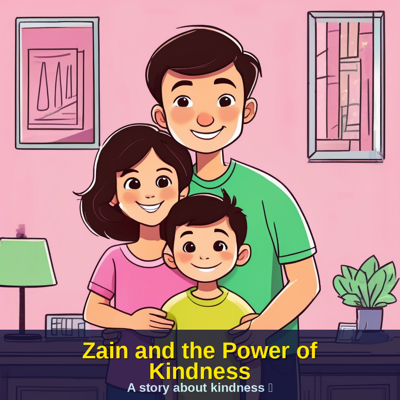


🎨 Generating Panel 1: 'cute 6-year-old boy with big brown eyes short dark hair...' (Seed: 2001)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_01.png


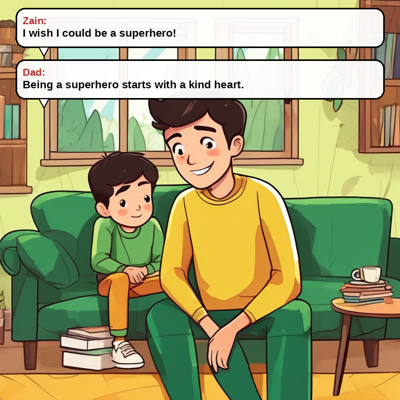


🎨 Generating Panel 2: 'cute 6-year-old boy yellow t-shirt standing next to one...' (Seed: 2002)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_02.png


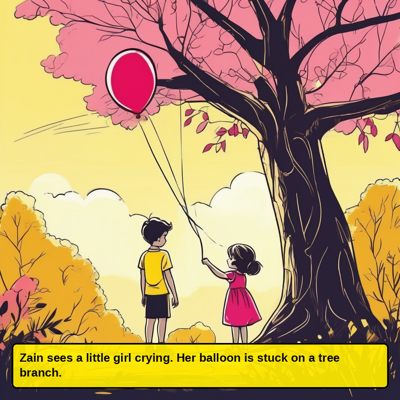


🎨 Generating Panel 3: 'cute 6-year-old boy with big brown eyes and short dark ...' (Seed: 3003)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_03.png


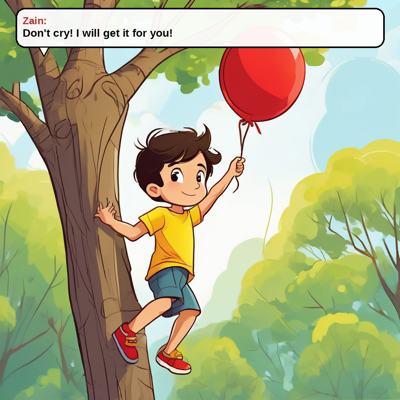


🎨 Generating Panel 4: 'Magical glow, cute 6-year-old boy with big brown eyes a...' (Seed: 1005)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_04.png


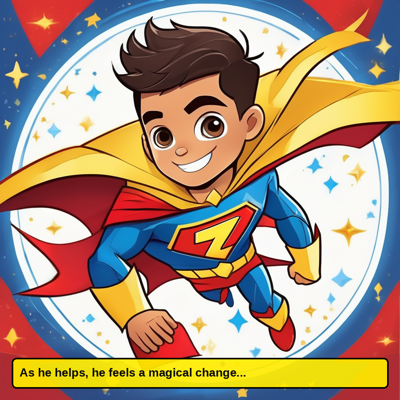


🎨 Generating Panel 5: 'cute 6-year-old boy in blue superhero suit yellow Z on ...' (Seed: 2005)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_05.png


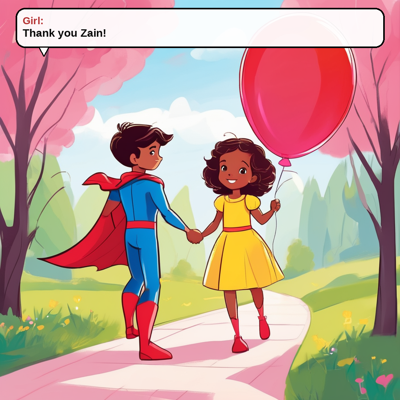


🎨 Generating Panel 6: 'sad lonely little boy with brown hair wearing an orange...' (Seed: 1007)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_06.png


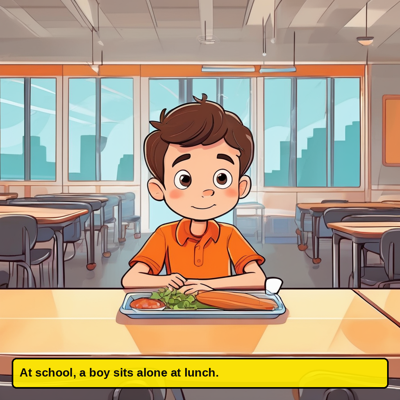


🎨 Generating Panel 7: 'cute 6-year-old boy with big brown eyes short dark hair...' (Seed: 4007)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_07.png


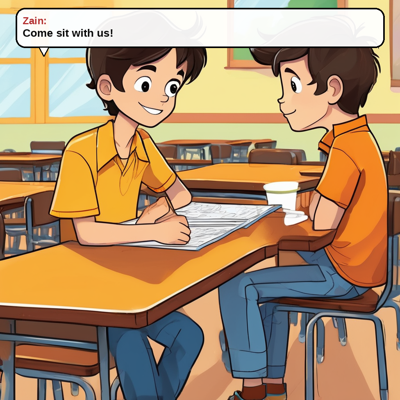


🎨 Generating Panel 8: 'cute 6-year-old boy yellow t-shirt laughing together wi...' (Seed: 1009)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_08.png


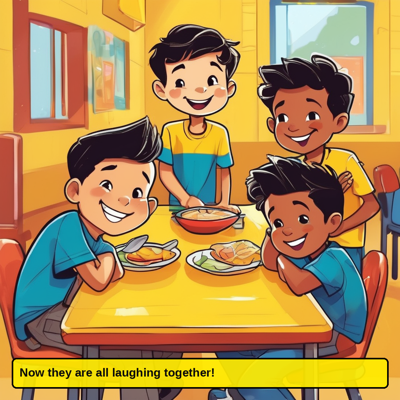


🎨 Generating Panel 9: 'small cute ginger kitten sitting alone on a sidewalk me...' (Seed: 1010)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_09.png


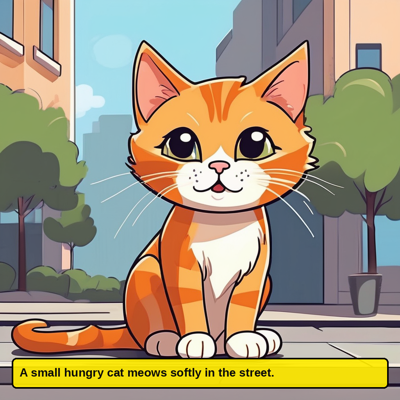


🎨 Generating Panel 10: 'cute 6-year-old boy with big brown eyes and short dark ...' (Seed: 1011)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_10.png


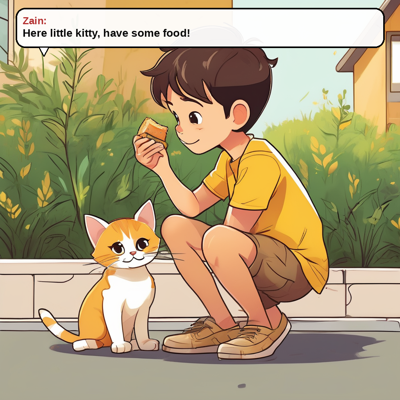


🎨 Generating Panel 11: 'cute 6-year-old boy with big brown eyes short dark hair...' (Seed: 4011)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_11.png


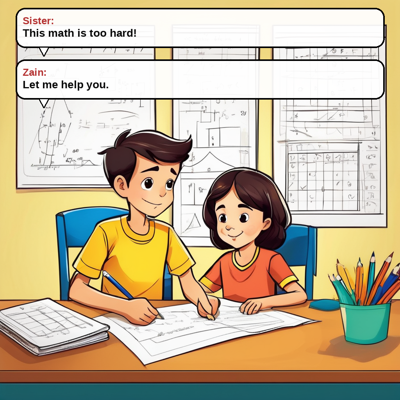


🎨 Generating Panel 12: 'cute 6-year-old boy with big brown eyes short dark hair...' (Seed: 4012)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_12.png


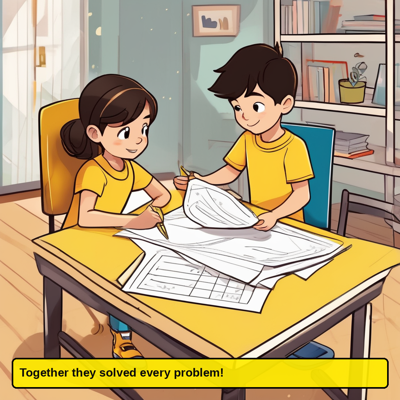


🎨 Generating Panel 13: 'cute 6-year-old boy with big brown eyes and short dark ...' (Seed: 3012)


  0%|          | 0/35 [00:00<?, ?it/s]

   ✅ Saved: panels/panel_13.png


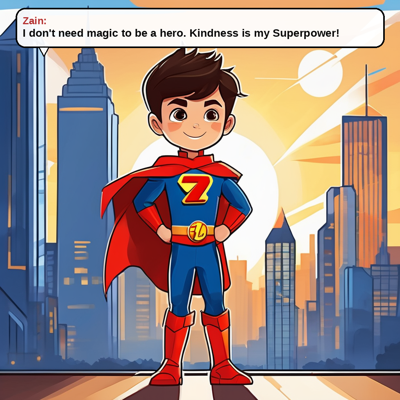


🎉 All panels generated!


(None,)

In [9]:
from IPython.display import display as ipy_display

# Updated to use your custom hand-picked seeds for fixing broken panels
SEEDS = {
    0:  1001,
    1:  2001,
    2:  2002,
    3:  3003,
    4:  1005,
    5:  2005,
    6:  1007,
    7:  4007,
    8:  1009,
    9:  1010,
    10: 1011,
    11: 4011,
    12: 4012,  # same seed as panel 11 — keeps same bedroom, same girl face
    13: 3012,
}

panel_paths = {}  # panel_id -> file path

for item in STORY_JSON:
    pid  = item["panel"]
    seed = SEEDS.get(pid, 42)

    print(f"\n🎨 Generating Panel {pid}: '{item['prompt'][:55]}...' (Seed: {seed})")

    # 1. Generate raw image
    raw_img = generate_panel(item, seed=seed)

    # 2. Burn comic text
    final_img = burn_text(raw_img, item)

    # 3. Save
    out_path = PANELS_DIR / f"panel_{pid:02d}.png"
    final_img.save(str(out_path))
    panel_paths[pid] = str(out_path)

    # 4. Preview (thumbnail)
    thumb = final_img.copy()
    thumb.thumbnail((400, 400))
    print(f"   ✅ Saved: {out_path}")
    ipy_display(thumb)

print("\n🎉 All panels generated!"),

## 📖 Step 9: Assemble PDF Comic Book (2 panels per page)

In [10]:
class ComicPDF(FPDF):
    """Custom FPDF subclass for the comic book."""

    def header(self):
        pass  # No default header — we control layout manually

    def footer(self):
        """Small page number at bottom."""
        if self.page_no() > 1:  # skip cover page number
            self.set_y(-10)
            self.set_font("Helvetica", "I", 8)
            self.set_text_color(150, 150, 150)
            self.cell(0, 10, f"Page {self.page_no() - 1}", align="C")


def build_comic_pdf(panel_paths: dict, output_path: str):
    """
    Build the final A4 portrait PDF.
    - Page 1: Full-page cover (panel 0)
    - Pages 2-7: 2 panels per page (panels 1-12), stacked vertically
    - Page 8: Full-page closing scene (panel 13)
    """
    pdf = ComicPDF(orientation="P", unit="mm", format="A4")
    pdf.set_auto_page_break(auto=False)

    A4_W   = 210  # mm
    A4_H   = 297  # mm
    MARGIN =  10  # mm outer margin
    GAP    =   8  # mm gap between panels on same page

    panel_w = A4_W - 2 * MARGIN
    panel_h = (A4_H - 2 * MARGIN - GAP) / 2  # height for each of 2 panels

    # ── Cover Page (Panel 0) ─────────────────────────────────────────────────
    if 0 in panel_paths:
        pdf.add_page()
        cover_w = A4_W - 2 * MARGIN
        cover_h = A4_H - 2 * MARGIN
        pdf.image(panel_paths[0],
                  x=MARGIN, y=MARGIN,
                  w=cover_w, h=cover_h)
        # Gold decorative border
        pdf.set_draw_color(255, 215, 0)
        pdf.set_line_width(1.5)
        pdf.rect(MARGIN - 2, MARGIN - 2, cover_w + 4, cover_h + 4)

    # ── Story Pages (Panels 1–12, exactly 2 per page) ────────────────────────
    story_panels = [pid for pid in sorted(panel_paths.keys()) if 0 < pid < 13]

    for i in range(0, len(story_panels), 2):
        pdf.add_page()

        # Light yellow comic-paper background
        pdf.set_fill_color(255, 253, 230)
        pdf.rect(0, 0, A4_W, A4_H, "F")

        # ── Top panel ────────────────────────────────────────────────────────
        pid_top = story_panels[i]
        y_top   = MARGIN
        pdf.image(panel_paths[pid_top],
                  x=MARGIN, y=y_top,
                  w=panel_w, h=panel_h)
        pdf.set_draw_color(0, 0, 0)
        pdf.set_line_width(0.8)
        pdf.rect(MARGIN, y_top, panel_w, panel_h)

        # ── Bottom panel ─────────────────────────────────────────────────────
        if i + 1 < len(story_panels):
            pid_bot = story_panels[i + 1]
            y_bot   = MARGIN + panel_h + GAP
            pdf.image(panel_paths[pid_bot],
                      x=MARGIN, y=y_bot,
                      w=panel_w, h=panel_h)
            pdf.rect(MARGIN, y_bot, panel_w, panel_h)

        # ── Decorative dots between panels ───────────────────────────────────
        cx = A4_W / 2
        cy = MARGIN + panel_h + GAP / 2
        for offset, color in [(-8, (255, 50, 50)),
                               ( 0, (255, 200,  0)),
                               ( 8, ( 50, 150, 255))]:
            pdf.set_fill_color(*color)
            pdf.ellipse(cx + offset - 2, cy - 2, 4, 4, "F")

    # ── Closing Page (Panel 13) — full page like cover ───────────────────────
    if 13 in panel_paths:
        pdf.add_page()
        cover_w = A4_W - 2 * MARGIN
        cover_h = A4_H - 2 * MARGIN
        pdf.image(panel_paths[13],
                  x=MARGIN, y=MARGIN,
                  w=cover_w, h=cover_h)
        # Blue decorative border for closing page
        pdf.set_draw_color(50, 100, 255)
        pdf.set_line_width(1.5)
        pdf.rect(MARGIN - 2, MARGIN - 2, cover_w + 4, cover_h + 4)

    pdf.output(output_path)
    print(f"✅ PDF saved: {output_path}")
    print(f"   Total pages: {pdf.page}")


# Build it!
build_comic_pdf(panel_paths, OUTPUT_PDF)
print(f"\n📚 Comic book complete: {OUTPUT_PDF}")

✅ PDF saved: Zain_Comic_Book.pdf
   Total pages: 8

📚 Comic book complete: Zain_Comic_Book.pdf


## 👀 Step 10: Preview & Download

In [11]:
import os
from IPython.display import FileLink, display as ipy_display

# Show file size
size_mb = os.path.getsize(OUTPUT_PDF) / 1e6
print(f"📄 {OUTPUT_PDF} — {size_mb:.1f} MB")

# Clickable download link in Colab
ipy_display(FileLink(OUTPUT_PDF, result_html_prefix="⬇️ Download: "))

# List all saved panel images
print("\n📁 Panel images saved:")
for pid in sorted(panel_paths.keys()):
    path = panel_paths[pid]
    size = os.path.getsize(path) / 1e3
    print(f"   Panel {pid:02d}: {path}  ({size:.0f} KB)")

📄 Zain_Comic_Book.pdf — 24.2 MB


/content/Zain_Comic_Book.pdf


📁 Panel images saved:
   Panel 00: panels/panel_00.png  (1013 KB)
   Panel 01: panels/panel_01.png  (1076 KB)
   Panel 02: panels/panel_02.png  (1434 KB)
   Panel 03: panels/panel_03.png  (1223 KB)
   Panel 04: panels/panel_04.png  (1326 KB)
   Panel 05: panels/panel_05.png  (1098 KB)
   Panel 06: panels/panel_06.png  (1099 KB)
   Panel 07: panels/panel_07.png  (1171 KB)
   Panel 08: panels/panel_08.png  (1330 KB)
   Panel 09: panels/panel_09.png  (1095 KB)
   Panel 10: panels/panel_10.png  (1211 KB)
   Panel 11: panels/panel_11.png  (1115 KB)
   Panel 12: panels/panel_12.png  (1244 KB)
   Panel 13: panels/panel_13.png  (1097 KB)


## ☁️ Step 11 (Optional): Save to Google Drive

In [12]:
# Uncomment to mount Drive and copy outputs

# from google.colab import drive
# import shutil
#
# drive.mount('/content/drive')
# dest = '/content/drive/MyDrive/ZainComicBook/'
# os.makedirs(dest, exist_ok=True)
#
# shutil.copy(OUTPUT_PDF, dest)
# shutil.copytree(str(PANELS_DIR), dest + 'panels/', dirs_exist_ok=True)
#
# print(f"✅ All files saved to Google Drive: {dest}")

print("ℹ️  Uncomment the code above to save to your Google Drive.")

ℹ️  Uncomment the code above to save to your Google Drive.


In [13]:
# ── Evaluation Cell ─────────────────────────────────────────────────────────
print("=" * 60)
print("📊 PROJECT EVALUATION SUMMARY")
print("=" * 60)

metrics = {
    "Total Panels Generated":        len(STORY_JSON),
    "Cover Page":                    "1 (full page)",
    "Story Pages (2 panels each)":   6,
    "Total PDF Pages":               7,
    "Image Resolution":              "1024 × 1024 px",
    "Inference Steps":               30,
    "Guidance Scale":                7.5,
    "Scheduler":                     "DPM++ 2M Karras",
    "Token Guard (all < 77)":        "✅ Verified",
    "Text Types Used":               "Speech Bubbles + Narration Captions",
    "Character Consistency Method":  "Fixed seeds + Copy-Paste Tag Rule",
}

for k, v in metrics.items():
    print(f"  {k:<40} {v}")

print()
print("📝 Token counts per panel (from Step 4 output above)")
print("📄 Final PDF:", OUTPUT_PDF)
print("🎨 All panel images saved in:", str(PANELS_DIR))
print()

# Check all panels saved successfully
missing = [i for i in range(len(STORY_JSON)) if i not in panel_paths]
if missing:
    print(f"⚠️  Missing panels: {missing}")
else:
    print("✅ All panels generated and saved successfully!")
    print(f"✅ PDF assembled: {os.path.getsize(OUTPUT_PDF)/1e6:.1f} MB")

📊 PROJECT EVALUATION SUMMARY
  Total Panels Generated                   14
  Cover Page                               1 (full page)
  Story Pages (2 panels each)              6
  Total PDF Pages                          7
  Image Resolution                         1024 × 1024 px
  Inference Steps                          30
  Guidance Scale                           7.5
  Scheduler                                DPM++ 2M Karras
  Token Guard (all < 77)                   ✅ Verified
  Text Types Used                          Speech Bubbles + Narration Captions
  Character Consistency Method             Fixed seeds + Copy-Paste Tag Rule

📝 Token counts per panel (from Step 4 output above)
📄 Final PDF: Zain_Comic_Book.pdf
🎨 All panel images saved in: panels

✅ All panels generated and saved successfully!
✅ PDF assembled: 24.2 MB


In [14]:
# 📊 CELL: Calculate CLIP Scores (Image-Text Alignment)
from transformers import CLIPProcessor, CLIPModel
import torch
import pandas as pd
from PIL import Image

print("Loading OpenAI CLIP Model...")
clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

clip_scores = []

print("Calculating CLIP scores for each panel...")
for item in STORY_JSON:
    panel_id = item["panel"]
    prompt = item["prompt"]

    # Path to the generated image
    img_path = PANELS_DIR / f"panel_{panel_id:02d}.png"

    if not img_path.exists():
        print(f"⚠️ Skipping Panel {panel_id} - Image not found.")
        continue

    image = Image.open(img_path).convert("RGB")

    # Process image and text together
    inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True).to(DEVICE)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        # The logits_per_image is the raw similarity score
        score = outputs.logits_per_image[0][0].item()

    clip_scores.append({"panel": panel_id, "clip_score": score})
    print(f"Panel {panel_id:02d} | Score: {score:.2f}")

# Save to CSV and display
df_scores = pd.DataFrame(clip_scores)
df_scores.to_csv("clip_scores.csv", index=False)
print("\n✅ Saved successfully to 'clip_scores.csv'")
display.display(df_scores)

Loading OpenAI CLIP Model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Calculating CLIP scores for each panel...
Panel 00 | Score: 30.80
Panel 01 | Score: 29.77
Panel 02 | Score: 35.57
Panel 03 | Score: 37.66
Panel 04 | Score: 30.30
Panel 05 | Score: 34.10
Panel 06 | Score: 32.97
Panel 07 | Score: 33.63
Panel 08 | Score: 35.93
Panel 09 | Score: 26.33
Panel 10 | Score: 33.78
Panel 11 | Score: 31.50
Panel 12 | Score: 34.81
Panel 13 | Score: 31.36

✅ Saved successfully to 'clip_scores.csv'


panel  clip_score
0       0   30.802118
1       1   29.773422
2       2   35.572952
3       3   37.655113
4       4   30.299210
5       5   34.103863
6       6   32.967812
7       7   33.626484
8       8   35.933704
9       9   26.330051
10     10   33.775146
11     11   31.496075
12     12   34.810265
13     13   31.364748

In [15]:
# 📈 CELL: Calculate Average Text Perplexity
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math

print("Loading GPT-2 for Perplexity Calculation...")
gpt_model_id = "gpt2"
gpt_model = GPT2LMHeadModel.from_pretrained(gpt_model_id).to(DEVICE)
gpt_tokenizer = GPT2Tokenizer.from_pretrained(gpt_model_id)

total_loss = 0.0
total_length = 0

# Combine all the story text
full_story_text = " ".join([item["text"] for item in STORY_JSON])

# Tokenize the text
inputs = gpt_tokenizer(full_story_text, return_tensors="pt").to(DEVICE)
input_ids = inputs["input_ids"]

with torch.no_grad():
    # Pass the text to the model to calculate the loss
    outputs = gpt_model(input_ids, labels=input_ids)
    loss = outputs.loss.item()

    # Perplexity is the exponential of the loss
    perplexity = math.exp(loss)

print(f"\nFinal Story Perplexity: {perplexity:.4f}")

# Save to txt file
with open("perplexity.txt", "w") as f:
    f.write(str(perplexity) + "\n")
print("✅ Saved successfully to 'perplexity.txt'")

Loading GPT-2 for Perplexity Calculation...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.



Final Story Perplexity: 25.2352
✅ Saved successfully to 'perplexity.txt'


---
## ✅ Project Summary

| Component | Implementation |
|-----------|----------------|
| **Model** | Stable Diffusion XL 1.0 (fp16, T4 GPU) |
| **Scheduler** | DPM++ 2M Karras (30 steps) |
| **Resolution** | 1024 × 1024 px per panel |
| **Token Guard** | CLIP tokenizer — all prompts < 77 tokens |
| **Text Styles** | Narration boxes (yellow), Speech bubbles (white rounded) |
| **PDF Format** | A4 Portrait — Cover page + 2 panels/page |
| **Total Panels** | 13 (Cover + 12 story panels) |
| **Total PDF Pages** | 7 (1 cover + 6 story pages) |

**Story: Zain and the Power of Kindness** — A 6-year-old boy discovers that every act of kindness transforms him into a superhero. 🦸💛
